# This notebook is for analysis

## Loading and processing
Here I will do all of the manipulation, processing and transformation of the data, motivating it either by its intrinsic value or by later usage.

First we import all the data and get a summary of it.

In [1]:
import pandas as pd
data = pd.read_csv('ScrapedPrices.csv')
data.head(), data.describe()

(             Adresse                   Post nr.       Pris    År  \
 0   Munkerodgyden 11    Stegsted, 5200 Odense V  3000000.0  2025   
 1        Lodsvej 25B       Stige, 5270 Odense N   803200.0  2024   
 2      Assensvej 243   Bellinge, 5250 Odense SV   844500.0  2024   
 3      Blommehaven 2     Bullerup, 5320 Agedrup   865850.0  2023   
 4  Planteskolevej 17  Holmstrup, 5250 Odense SV  1170000.0  2023   
 
    Størrelse (m2)  Værelser  Toiletter   Handel  
 0             274         6          2  Auktion  
 1             141         6          2  Auktion  
 2             153         5          2  Auktion  
 3             139         6          1  Auktion  
 4             184         7          2  Auktion  ,
                Pris            År  Størrelse (m2)      Værelser     Toiletter
 count  1.077100e+04  10771.000000    10771.000000  10771.000000  10771.000000
 mean   2.805764e+06   2022.394392      121.510073      4.158945      1.506731
 std    3.634173e+06      1.293101      

From the information above we conclude that there are 10777 properties in the dataset. We have houses tracking back all the way to 2019 which we shouldn't since the search term in the scraping should be from 2020 and onwards. The most expensive house is one sold for 80 million danish crowns. 

Let us do a sanity check and see what house this is.

In [2]:
most_expensive_house = data[data['Pris']==80*10**6]
most_expensive_house

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel
8895,Falen 61C,5000 Odense C,80000000.0,2021,59,2,1,Fri handel


We see that the most expensive house in the dataset is 59 square meter apartment sold for 80 million danish crowns back in 2021 - (link to the apartment:https://www.boligsiden.dk/adresse/falen-61c-5000-odense-c-04612188_61c_______)

This does not immediately make sense, but the scraping has been done successfully, since the property does exist from the pages we scraped from. This we will later consider an outlier.

I want to look at the distribution of the properties on the ZIP codes and the years, to see if we have fairly similar distributions as to not skew towards a category favourly later.

In [3]:
data['Post nr.'].value_counts(), data['År'].value_counts(), data['Adresse'].value_counts()

(Post nr.
 5000 Odense C                    2727
 5230 Odense M                     916
 Sanderum, 5250 Odense SV          519
 Hjallese, 5260 Odense S           495
 Dalum, 5250 Odense SV             454
                                  ... 
 Ejlstrup, 5491 Blommenslyst         2
 Hesbjerg, 5491 Blommenslyst         2
 Tarup, 5000 Odense C                2
 L Hesbjerg, 5491 Blommenslyst       1
 Højby, 5220 Odense SØ               1
 Name: count, Length: 87, dtype: int64,
 År
 2021    2938
 2024    2626
 2023    2329
 2022    2186
 2020     463
 2025     203
 2019      26
 Name: count, dtype: int64,
 Adresse
 Højstrupvangen 31     2
 Skovhaven 113         2
 Kærbygade 22          2
 Windelsvej 68         2
 Vangelystvej 40       2
                      ..
 Spiræavænget 8        1
 Saxovej 166           1
 Fengersvej 32, st.    1
 Fengersvej 32, 1.     1
 Rughavevej 4, 1.      1
 Name: count, Length: 10723, dtype: int64)

We see that there are addresses that appear twice in the dataset. 

In [4]:
double_address = data[data['Adresse'] == 'Højstrupvangen 31']
double_address

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel
9983,Højstrupvangen 31,"Bolbro, 5200 Odense V",1310000.0,2021,61,2,1,Fri handel
9984,Højstrupvangen 31,"Bolbro, 5200 Odense V",1310000.0,2021,61,2,1,Fri handel


There are duplicates in the dataset, let us remove them.

In [5]:
data = data.drop_duplicates()
data[data['Adresse'] == 'Højstrupvangen 31'], data['Adresse'].value_counts()

(                Adresse               Post nr.       Pris    År  \
 9983  Højstrupvangen 31  Bolbro, 5200 Odense V  1310000.0  2021   
 
       Størrelse (m2)  Værelser  Toiletter      Handel  
 9983              61         2          1  Fri handel  ,
 Adresse
 Munkerodgyden 11              1
 Rulkedalen 86                 1
 Hjulets Kvarter 48            1
 Persillehaven 31              1
 Læssøegade 89, st.            1
                              ..
 Nellikevej 16                 1
 Gyldenløvesgade 11, 1. tv.    1
 Vinkældervej 40, 1. tv.       1
 Sanderumvej 140A              1
 Rughavevej 4, 1.              1
 Name: count, Length: 10723, dtype: int64)

It wasn't really a problem that an address would appear twice in the dataset. It could just mean that the sold has been sold twice in the period from 2019 till current time. But we see that this hasn't been the case for any of the addresses appearing twice in the dataset. We also lost a significant portion of houses somewhere in the ballpark of 800.

I want to compute a normalized price for 2025. But before that I want to change the scale of the number from being in the millions and hundred thousands to be less than 100.

In [6]:
data['Pris i mio. kr.'] = data['Pris']/(10**6)

House prices fluctuate over time, but I want to eliminate that as a factor and make a normalized price to be used for training later. A recurring theme when scrolling through pages of information about the housing market in Odense municipality, is that we witnessed a drop in price in 2022. This should obviously be accounted for. With this page(link: https://www.boliga.dk/boligpriser/resultater?area=77461&type=1&data=0) I can somewhat normalize the prices into a current 2025 one.

In [7]:
price_2019, price_2020, price_2021, price_2022, price_2023, price_2024 = 2854, 22970, 23836, 24639, 21633, 21632
increase_2019, increase_2020, increase_2021, increase_2022, increase_2023 = price_2024/price_2019, price_2024/price_2020, price_2024/price_2021, price_2024/price_2022, price_2024/price_2023
convertion = {
    2019: increase_2019,
    2020: increase_2020,
    2021: increase_2021,
    2022: increase_2022,
    2023: increase_2023,
    2024: 1,
    2025: 1
}
data['Normaliseret Pris (2025)'] = data.apply(lambda row: convertion[row.År]*row.Pris, axis=1)
data['Normaliseret Pris i mio. kr. (2025)'] = data.apply(lambda row: convertion[row.År]*row['Pris i mio. kr.'], axis=1)
data

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel,Pris i mio. kr.,Normaliseret Pris (2025),Normaliseret Pris i mio. kr. (2025)
0,Munkerodgyden 11,"Stegsted, 5200 Odense V",3000000.0,2025,274,6,2,Auktion,3.00000,3.000000e+06,3.000000
1,Lodsvej 25B,"Stige, 5270 Odense N",803200.0,2024,141,6,2,Auktion,0.80320,8.032000e+05,0.803200
2,Assensvej 243,"Bellinge, 5250 Odense SV",844500.0,2024,153,5,2,Auktion,0.84450,8.445000e+05,0.844500
3,Blommehaven 2,"Bullerup, 5320 Agedrup",865850.0,2023,139,6,1,Auktion,0.86585,8.658100e+05,0.865810
4,Planteskolevej 17,"Holmstrup, 5250 Odense SV",1170000.0,2023,184,7,2,Auktion,1.17000,1.169946e+06,1.169946
...,...,...,...,...,...,...,...,...,...,...,...
10766,Buen 31,"Bullerup, 5320 Agedrup",950000.0,2020,93,2,1,Fri handel,0.95000,8.946626e+05,0.894663
10767,Vårvangen 7,"Skt Klemens, 5260 Odense S",2660000.0,2020,166,6,2,Fri handel,2.66000,2.505055e+06,2.505055
10768,"Thuresensgade 36, st. th.",5000 Odense C,913000.0,2020,47,1,1,Fri handel,0.91300,8.598178e+05,0.859818
10769,Sukkeræble Have 5,"Villestofte, 5210 Odense NV",4895000.0,2020,216,5,2,Fri handel,4.89500,4.609867e+06,4.609867


This might be revisited in favor of more sophisticated or accurate approaches, but for now it will do.

For easier and comprehensive visualization I will add a column of the ZIP codes with only digits.

In [8]:
import re
data['Post nr.(kun tal)'] = data['Post nr.'].apply(lambda nr: re.findall(r'\d\d\d\d',nr)[0])

In [9]:
ZIP_code_counts = data['Post nr.'].value_counts().reset_index()
data['Post nr.(kun tal)'].value_counts(), ZIP_code_counts[ZIP_code_counts['count']<100]

(Post nr.(kun tal)
 5000    2729
 5250    1681
 5270    1265
 5210    1110
 5260    1021
 5230     916
 5220     677
 5240     483
 5200     457
 5320     288
 5491      92
 5330       4
 Name: count, dtype: int64,
                          Post nr.  count
 25         Anderup, 5270 Odense N     99
 26        Ejlstrup, 5200 Odense V     88
 27    Villestofte, 5210 Odense NV     83
 28      Tornbjerg, 5220 Odense SØ     79
 29         Paarup, 5210 Odense NV     73
 ..                            ...    ...
 82    Ejlstrup, 5491 Blommenslyst      2
 83    Hesbjerg, 5491 Blommenslyst      2
 84           Tarup, 5000 Odense C      2
 85  L Hesbjerg, 5491 Blommenslyst      1
 86          Højby, 5220 Odense SØ      1
 
 [62 rows x 2 columns])

Some import information is revealed here. Only a few houses can be found for the ZIP code 5491 and 5330. Instead of dividing these even more by their locations I will only work with their numeric values.

## Exploration
Here I explore the connection between the different explanatory variables and the price.

Something else I want to do is look at the impact of different transaction types impact on the price.

Handel
Fri handel       9657
Familiehandel    1042
Auktion            24
Name: count, dtype: int64

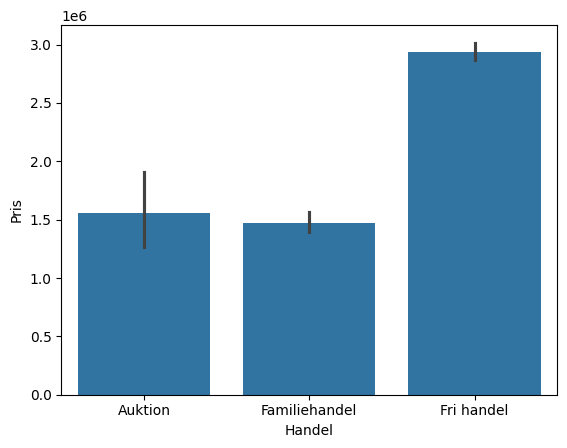

In [10]:
import seaborn as sns
sns.barplot(data=data, x='Handel', y='Pris')
data['Handel'].value_counts()

We see clearly the distinction between the different types and we are really only interested in predicting houses that are traded under market terms. For auctions we have a low sample size, but even when accounting for the variance we are nowhere near free market prices. Perhaps the other types could be interesting for a different task, but not this one! I keep the free trade ones.

In [11]:
data = data[data['Handel'] == 'Fri handel']

I want to look at the distribution of the prices in general.

[Text(0.5, 0, 'Pris i 2023')]

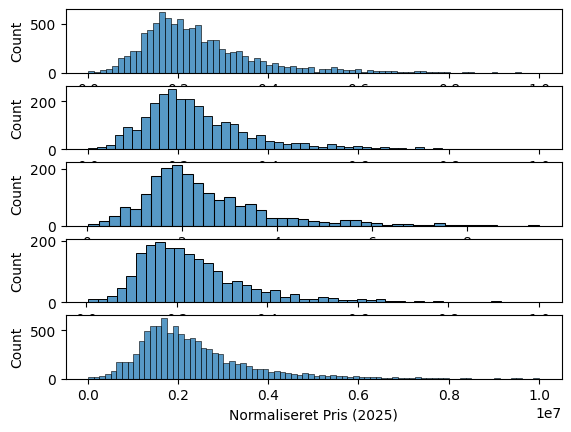

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1)
sns.histplot(data=data[data['Pris'] <= 10*10**6],x='Pris', ax=ax[0])
sns.histplot(data=data[(data['Pris'] <= 10*10**6) & (data['År'] == 2021)],x='Pris', ax=ax[1])
sns.histplot(data=data[(data['Pris'] <= 10*10**6) & (data['År'] == 2022)],x='Pris', ax=ax[2])
sns.histplot(data=data[(data['Pris'] <= 10*10**6) & (data['År'] == 2023)],x='Pris', ax=ax[3])
sns.histplot(data=data[data['Normaliseret Pris (2025)'] <= 10*10**6],x='Normaliseret Pris (2025)', ax=ax[4])
ax[1].set(xlabel='Pris i 2021')
ax[2].set(xlabel='Pris i 2022')
ax[3].set(xlabel='Pris i 2023')

The points of these plots were to see if there would be more of a resemblance for each year to the normalized prices than to all the prices unadjusted. What could be attempted is something like a Kolmogorov-Smirnov test, to see if the adjusted data lines up better with the yearly prices better than the unadjusted prices pooled together.

In [13]:
data[data['Pris']<100000]

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel,Pris i mio. kr.,Normaliseret Pris (2025),Normaliseret Pris i mio. kr. (2025),Post nr.(kun tal)
3336,Damhavevej 41,"Stenløse, 5260 Odense S",37268.0,2024,215,6,2,Fri handel,0.037268,37268.000000,0.037268,5260
3792,Tyrsbjergvej 59,"Villestofte, 5210 Odense NV",60000.0,2023,171,7,2,Fri handel,0.060000,59997.226460,0.059997,5210
3901,Bindekildevej 19,"Bellinge, 5250 Odense SV",60750.0,2023,167,4,1,Fri handel,0.060750,60747.191790,0.060747,5250
3908,Assensvej 205,"Bellinge, 5250 Odense SV",60750.0,2023,349,8,3,Fri handel,0.060750,60747.191790,0.060747,5250
4138,Ravnebjerggyden 31,"Lille Ubberud, 5491 Blommenslyst",60000.0,2023,235,7,2,Fri handel,0.060000,59997.226460,0.059997,5491
4263,Højbyvej 2,"Højby, 5260 Odense S",57687.0,2023,178,4,1,Fri handel,0.057687,57684.333380,0.057684,5260
5379,Hedelundvej 10,"Stige, 5270 Odense N",40891.0,2023,209,4,1,Fri handel,0.040891,40889.109786,0.040889,5270
6056,Skovmålvej 26,"Aasum, 5320 Agedrup",80000.0,2022,324,8,2,Fri handel,0.080000,70236.616746,0.070237,5320
6272,Nr. Lyndelse Vej 17A,"Højby, 5260 Odense S",50000.0,2022,322,8,3,Fri handel,0.050000,43897.885466,0.043898,5260
6278,Nr. Lyndelse Vej 17B,"Højby, 5260 Odense S",50000.0,2022,120,2,1,Fri handel,0.050000,43897.885466,0.043898,5260


Next I want to look at each explanatory variable individually to see how it impacts the price.

<Axes: xlabel='Størrelse (m2)', ylabel='Pris'>

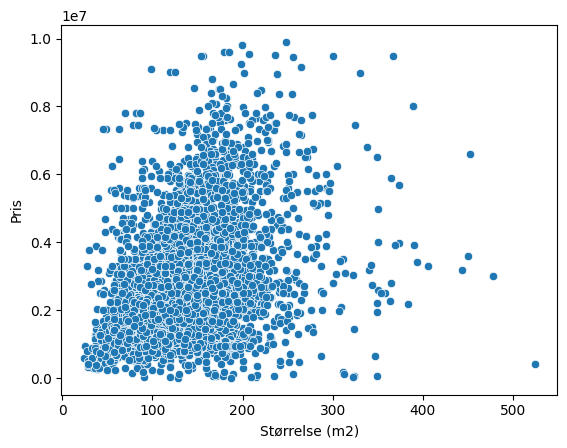

In [14]:
sns.scatterplot(data=data[data['Pris']<10*10**6], x='Størrelse (m2)', y='Pris') #I filter out some of the extreme prices for visualization purposes.

We see some strange cases popping up already. A 500 (m2) house selling for almost nothing. Let us check that out.

In [15]:
biggest_house = data[data['Størrelse (m2)']>500]
biggest_house

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel,Pris i mio. kr.,Normaliseret Pris (2025),Normaliseret Pris i mio. kr. (2025),Post nr.(kun tal)
1262,Vestermarksvej 50,"Fangel, 5260 Odense S",413954.0,2024,524,8,3,Fri handel,0.413954,413954.0,0.413954,5260


Again, the scraping has been performed correctly, but we have an anamoly in terms of price. We see that this is a 'fri handel' which means the purchase happened under regular conditions. An explaining factor could have been low bids at an auction or selling at a discount to family - (link to the house:https://www.boligsiden.dk/adresse/vestermarksvej-50-5260-odense-s-04619297__50_______)

What else can be said about the plot, is that there is some positive correlation, resulting in a cone like shape. But we make calculations that to make sure.

In [16]:
from scipy.stats import spearmanr
spearman_corr = spearmanr(data['Størrelse (m2)'],data['Pris'])
spearman_corr

SignificanceResult(statistic=np.float64(0.47694171793793544), pvalue=np.float64(0.0))

There is definite positive correlation between the two with the p-value being 0. So it is fair to assume that price and size is positively correlated(duh). What I could do now is check for bathrooms and toilets, but most likely these two variables will be positively correlated with the size and so it won't make much sense.

In [17]:
data[['Størrelse (m2)', 'Toiletter', 'Værelser']].corr('spearman')

,Størrelse (m2),Toiletter,Værelser
Størrelse (m2),1.000000,0.686127,0.814479
Toiletter,0.686127,1.000000,0.598557
Værelser,0.814479,0.598557,1.000000


We see exactly what was conjectured, that the number of rooms or toilets is positively correlated with the size.

From the code below we see that the number of unique ZIP codes is 87. We want to get a visual idea of what the impact of location is on the price and hopefully visually.

In [18]:
ZIP_codes = data['Post nr.'].unique()
len(ZIP_codes)

83

Below I want to look at the distribution of prices for each ZIP code, but only the numeric part of it.

<Axes: xlabel='Post nr.(kun tal)', ylabel='Normaliseret Pris i mio. kr. (2025)'>

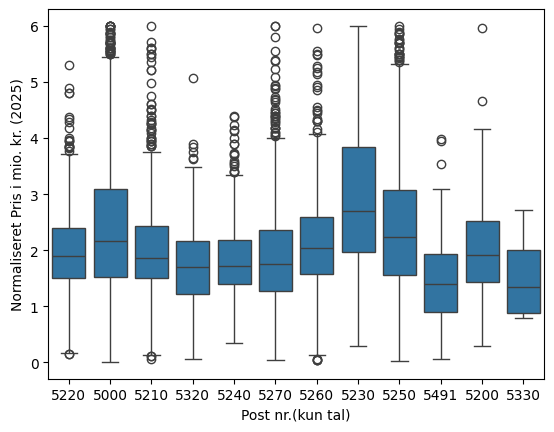

In [19]:
sns.boxplot(data=data[data['Normaliseret Pris i mio. kr. (2025)']<6], x='Post nr.(kun tal)', y='Normaliseret Pris i mio. kr. (2025)')

As you see in the code I filtered out houses sold for more than 6 million danish crowns. When the boxplot quantiles end and the points appears as dots, that means in the framework of considering the 4 quantiles that they are outliers. What we could do is remove all of the houses that fall out of category, but that might be overreaching. Neighborhoods in Odense will consist of a lot of mixed value houses and properties and not be completely homogenuous. What is of greater concern, is the properties that are huge and sells for peanuts. Under free trade rules it seems suspicious. I think it is fair to consider these as anomalies. All properties under 500k should be investigated.

In [20]:
data[data['Normaliseret Pris (2025)']<=0.5*10**6]

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel,Pris i mio. kr.,Normaliseret Pris (2025),Normaliseret Pris i mio. kr. (2025),Post nr.(kun tal)
1094,Møllegyden 7,"Brændekilde, 5250 Odense SV",300000.0,2025,70,3,1,Fri handel,0.300000,300000.000000,0.300000,5250
1102,Fuglebakken 38M,"Snestrup, 5210 Odense NV",450000.0,2025,43,2,1,Fri handel,0.450000,450000.000000,0.450000,5210
1110,Fuglsang 10D,"Næsby, 5270 Odense N",315000.0,2025,35,2,1,Fri handel,0.315000,315000.000000,0.315000,5270
1111,Fuglsang 10A,"Næsby, 5270 Odense N",315000.0,2025,37,2,1,Fri handel,0.315000,315000.000000,0.315000,5270
1127,Fangel Bygade 34,"Fangel, 5260 Odense S",215819.0,2025,108,3,2,Fri handel,0.215819,215819.000000,0.215819,5260
...,...,...,...,...,...,...,...,...,...,...,...,...
10082,Spurvelunden 12,"Næsbyhoved-Broby, 5270 Odense N",500000.0,2021,151,5,2,Fri handel,0.500000,453767.410639,0.453767,5270
10176,Hegningvej 7,"Lindved, 5260 Odense S",505000.0,2021,53,2,1,Fri handel,0.505000,458305.084746,0.458305,5260
10179,Fangelvej 31,"Fangel, 5260 Odense S",467080.0,2021,251,8,2,Fri handel,0.467080,423891.364323,0.423891,5260
10481,Espestok 54B,"Gammel Korup, 5210 Odense NV",120000.0,2021,130,3,1,Fri handel,0.120000,108904.178553,0.108904,5210


Take for example Espestok 54A, bottom of the list. It sold for 120 thousand danish crowns in 2021, but for 6.3 million danish crowns in 2015. Something has obviously happened or the reporting is just plain wrong. According to Danish law it's okay to sell below public evaluation if there are no familial ties between the two parties. I am going to filter out houses which price deviates way too much from the price per m2. If a house is sold for less than a fourth of the price based on the square meters, it is an anomaly of have been very troubling to sell. Which is a fair reason for our project(could have used how long it was listed for, maybe in newer iterations), but selling for less than a fourth of what the square meter price is on average for the whole municipality is quite extreme, in my opinion.

In [21]:
m2_price = 18000
data = data[data['Normaliseret Pris (2025)']>=data['Størrelse (m2)']*(m2_price/4)]

Let us see if we have properties on the other side of the spectrum.

In [22]:
data[data['Normaliseret Pris (2025)']>=data['Størrelse (m2)']*(m2_price*10)]

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel,Pris i mio. kr.,Normaliseret Pris (2025),Normaliseret Pris i mio. kr. (2025),Post nr.(kun tal)
1525,Over-Holluf-Toften 39,"Over Holluf, 5220 Odense SØ",41000000.0,2024,146,7,2,Fri handel,41.000000,4.100000e+07,41.000000,5220
1526,Over-Holluf-Toften 81,"Over Holluf, 5220 Odense SØ",41000000.0,2024,158,6,2,Fri handel,41.000000,4.100000e+07,41.000000,5220
1527,Over-Holluf-Toften 73,"Over Holluf, 5220 Odense SØ",41000000.0,2024,158,6,2,Fri handel,41.000000,4.100000e+07,41.000000,5220
1528,Over-Holluf-Toften 71,"Over Holluf, 5220 Odense SØ",41000000.0,2024,158,6,2,Fri handel,41.000000,4.100000e+07,41.000000,5220
1529,Over-Holluf-Toften 57,"Over Holluf, 5220 Odense SØ",41000000.0,2024,158,6,2,Fri handel,41.000000,4.100000e+07,41.000000,5220
...,...,...,...,...,...,...,...,...,...,...,...,...
10364,Amaliehaven 148,"Seden, 5240 Odense NØ",19097471.0,2021,87,3,1,Fri handel,19.097471,1.733162e+07,17.331620,5240
10365,Amaliehaven 176,"Seden, 5240 Odense NØ",19097471.0,2021,87,3,1,Fri handel,19.097471,1.733162e+07,17.331620,5240
10377,"Nyborgvej 1A, 1. th.",5000 Odense C,21250000.0,2021,47,2,1,Fri handel,21.250000,1.928511e+07,19.285115,5000
10430,Astrupvej 40A,5000 Odense C,24150000.0,2021,69,2,1,Fri handel,24.150000,2.191697e+07,21.916966,5000


There are quite a lot of properties going for more than 10 times the average square meter price, which is absurd. The top of the list are all sold for way less than 41 million danish crowns previously. So I filter these away as well. I am quite certain that there are more suspicious properties on this side of things, but we are going to leave it for now.

In [23]:
data = data[data['Normaliseret Pris (2025)']<data['Størrelse (m2)']*(m2_price*10)]

The last thing I want to do is just quickly look at the importance of each feature in predicting and I do this by running the data through a decision tree. The decision tree can report back the information gained on each split.

In [24]:
from sklearn.tree import DecisionTreeRegressor
feature_importance = DecisionTreeRegressor()

We still need a reasonable way to encode the ZIP codes. There is no inherent ranking to the ZIP codes, but we can try to encode them based on average values. We can also do it randomly, but this arbitrary division would just be confusing for the model. Other alternatives could be making two new variables - one that encodes where it is located vertically on a map and one for the horizontal position. This way the splits could happen in a more reasonable manner with reading direction. 
For now I stick with ordering them in terms of their median(to avoid skewness) price. Hope this does not lead to too much overfitting

In [25]:
ranked = data[['Normaliseret Pris (2025)','Post nr.']].groupby('Post nr.').median().sort_values('Normaliseret Pris (2025)').reset_index()
encodings = {ZIP:index+1 for index, ZIP in enumerate(list(ranked['Post nr.']))}
data['Post nr. (kodet)'] = data['Post nr.'].apply(lambda ZIP: encodings[ZIP])

Now we have encoded the ZIP codes in a more meaningful way. This could lead to overfitting and will be considered for the last results. 

In [26]:
features, target = data[['Post nr. (kodet)', 'Størrelse (m2)', 'Værelser', 'Toiletter']], data['Normaliseret Pris (2025)']
feature_importance.fit(features,target)
feature_importance.feature_importances_

array([0.32148521, 0.5268043 , 0.11938612, 0.03232437])

Just to see if it skews the feature importance by encoding randomly.

In [27]:
random_encoding = {ZIP: i for i, ZIP in enumerate(data['Post nr.'].unique())}
data['Post nr. (kodet - tilfældigt)'] = data['Post nr.'].apply(lambda ZIP: random_encoding[ZIP])

And now checking.

In [28]:
features, target = data[['Post nr. (kodet - tilfældigt)', 'Størrelse (m2)', 'Værelser', 'Toiletter']], data['Normaliseret Pris (2025)']
feature_importance = DecisionTreeRegressor()
feature_importance.fit(features,target)
feature_importance.feature_importances_

array([0.29772441, 0.54487891, 0.11724279, 0.04015389])

It did slightly drop when encoding them arbitrarily. It should be mentioned that the ZIP codes might still arrive in some order unbeknownst to me. But arbitrary to my knowledge. Perhaps we can answer the question of overfitting already. Encoding the ZIP codes with median price in mind came with a small information gain. This information gain is both useful and alright, I would argue. EXPLAIN LATER

We see that the size of the property is the most important feature in both cases though.

In [29]:
data

,Adresse,Post nr.,Pris,År,Størrelse (m2),Værelser,Toiletter,Handel,Pris i mio. kr.,Normaliseret Pris (2025),Normaliseret Pris i mio. kr. (2025),Post nr.(kun tal),Post nr. (kodet),Post nr. (kodet - tilfældigt)
1068,Klokkens Kvarter 26,"Holluf Pile, 5220 Odense SØ",2500000.0,2025,114,4,1,Fri handel,2.5000,2.500000e+06,2.500000,5220,38,0
1069,"Prinsesse Maries Allé 1, st.",5000 Odense C,887500.0,2025,70,2,1,Fri handel,0.8875,8.875000e+05,0.887500,5000,60,1
1070,Njalsvej 199,"Højstrup, 5210 Odense NV",1650000.0,2025,78,4,1,Fri handel,1.6500,1.650000e+06,1.650000,5210,13,2
1071,Æblehaven 9,"Bullerup, 5320 Agedrup",2200000.0,2025,134,4,1,Fri handel,2.2000,2.200000e+06,2.200000,5320,23,3
1072,Egholmen 47,"Seden, 5240 Odense NØ",1575000.0,2025,110,4,2,Fri handel,1.5750,1.575000e+06,1.575000,5240,39,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10766,Buen 31,"Bullerup, 5320 Agedrup",950000.0,2020,93,2,1,Fri handel,0.9500,8.946626e+05,0.894663,5320,23,3
10767,Vårvangen 7,"Skt Klemens, 5260 Odense S",2660000.0,2020,166,6,2,Fri handel,2.6600,2.505055e+06,2.505055,5260,67,21
10768,"Thuresensgade 36, st. th.",5000 Odense C,913000.0,2020,47,1,1,Fri handel,0.9130,8.598178e+05,0.859818,5000,60,1
10769,Sukkeræble Have 5,"Villestofte, 5210 Odense NV",4895000.0,2020,216,5,2,Fri handel,4.8950,4.609867e+06,4.609867,5210,73,39


We are left with 9384 properties that are suitable for training and evaluation.

## Training

I want to designate all the test data as the data from 2024 and 2025 and then training on all the prior data.

In [30]:
training_data, test_data = data[~data['År'].isin([2024,2025])], data[data['År'].isin([2024,2025])]
features, target = ['Post nr. (kodet)','Værelser','Toiletter','Størrelse (m2)'], ['Normaliseret Pris (2025)']
X, y = training_data[features], training_data[target]

I will be training and validating by using k-fold cross validation.

In [31]:
from sklearn.model_selection import KFold
from collections import defaultdict
def get_folds(X,y,n):
    folds = defaultdict(list)
    fold = KFold(n_splits=n,shuffle=True)
    splits = fold.split(X)
    for i, (train_indices, val_indices) in enumerate(splits):
        X_train, y_train = X[X.index.isin(train_indices)], y[y.index.isin(train_indices)]
        X_val, y_val = X[X.index.isin(val_indices)], y[y.index.isin(val_indices)]
        folds[i+1] = (X_train, X_val, y_train, y_val)
    return folds

First I try with a random forest regressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
forest = RandomForestRegressor()
folds = get_folds(X,y,5)
scores = []
forest_predictions = []
for X_train, X_val, y_train, y_val in folds.values():
    forest.fit(X_train,y_train)
    predictions = forest.predict(X_val)
    score = mean_absolute_error(predictions,y_val)
    scores.append(score)
forest_mean_scores = np.mean(scores)
forest_mean_scores

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklea

np.float64(680196.7287793062)

Then we can try with XGBoost.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
grad = GradientBoostingRegressor()
folds = get_folds(X,y,5)
scores = []
for X_train, X_val, y_train, y_val in folds.values():
    grad.fit(X_train,y_train)
    predictions = grad.predict(X_val)
    scores.append(mean_absolute_error(predictions,y_val))
grad_mean_scores = np.mean(scores)
grad_mean_scores

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

np.float64(634957.7937266508)

It seems like a lot, but remember, we saw there was properties that completely broke with reality in terms of their listed price. So it could be a couple of properties that contribute with large deviations to the total error. But we can investigate that!
We could perhaps also lower the error by fine-tuning the parameters, but I am not too keen on that.

## Evaluation

In [34]:
grad.fit(X,y)
X_test, y_test = test_data[features], test_data[target]
predictions = grad.predict(X_test)
mean_absolute_error(predictions,y_test)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


670254.7682290105

Amazingly enough, not a bad performance compared to out validation results. So we generalize nicely with the model, which is good.

Pricing properties correctly is a difficult task(just read this: https://finans.dk/privatokonomi/ECE13528444/beregning-gabet-mellem-offentlig-ejendomsvurdering-og-salgspris-er-enormt/), but hopefully this notebook highlights my approach to modelling with data I have collected myself.

What could be an improvement of the model is to locate points of interest near each property.
\
How the property is heated and what material is used.
\
Try to weight the model with prices for the sales of the nearby properties.
\
COLLECT MORE DATA! The normalization seems to have been working fine. The training data has exclusively been data NOT from 2024 and 2025(which is like a fourth of the total data) where the prices were normalized to match what a 2024/25 equivalent could be and the mean score does deviate, but not by a lot! So we could just collect a lot more data and normalize it.